
# Project 3: Deep & Wide Nets, RNNs, Kernels & Regressions — UCI Wine Quality + Open‑Meteo Weather

Gather and refine wine-related chemical and weather data, extract key features, and develop a clean, structured dataset suitable for modeling and analysis.

### Data Gathering and Feature Engineering - Mike Maurrasse


We carry out Sections 1 and 2 using:
- **Dataset 1 (≥3k rows)**: UCI Wine Quality (red + white) — direct CSVs
- **Dataset 2 (API, ≥3k rows)**: Open‑Meteo ERA5 daily weather for the Vinho Verde region (Portugal), growing seasons across multiple years
- Full cleaning, imputation, IQR outlier handling, EDA, and ≥3 domain‑driven features
- Encoding (OHE/ordinal) + scaling via `ColumnTransformer`

> Note: UCI wines don’t include vintage or winery location; we treat weather as an **independent dataset** to satisfy the “two datasets” requirement and demonstrate domain features.



## How to run (Colab)
1. Run the pinned install cell below.  
2. Run the rest of the notebook top‑to‑bottom.


In [60]:

# Colab-friendly pins (avoid resolver conflicts)
!pip -q install "pandas==2.2.2" "numpy==2.0.2" \
                "scikit-learn==1.5.2" "matplotlib==3.9.2" \
                "requests==2.32.3" \
                --upgrade --no-warn-conflicts

import sys, numpy as np, pandas as pd
print("Python:", sys.version.split()[0], "| numpy:", np.__version__, "| pandas:", pd.__version__)


Python: 3.12.11 | numpy: 2.0.2 | pandas: 2.2.2


## Fixed random seeds & imports

In [61]:

import os, random, io, time, re, math, json
from datetime import date, datetime, timedelta
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED); np.random.seed(SEED)
plt.rcParams["figure.figsize"] = (7,4)
print("Seeds set:", SEED)


Seeds set: 42



---
## 1) Data Gathering & Description
We collect **two original datasets** (≥ 3,000 rows each, ≥ 5 features). One is fetched via an **API**.



### 1.1 Wine Quality (UCI) — direct CSVs (no login)
Sources: two CSVs for red and white Vinho Verde wines; we concatenate and tag with `type`.


In [62]:

import pandas as pd

RED = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
WHITE = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

def load_uci_wine():
    red = pd.read_csv(RED, sep=";").assign(type="red")
    white = pd.read_csv(WHITE, sep=";").assign(type="white")
    df = pd.concat([red, white], ignore_index=True)
    # Standardize column names
    df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]
    return df

wine_df = load_uci_wine()
print("Wine shape:", wine_df.shape)
try:
    display(wine_df.head(5))
except Exception:
    print(wine_df.head(5).to_string(index=False))


Wine shape: (6497, 13)


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red



**Engineering notes (2–3 sentences):** The UCI CSVs use semicolon separators and include only physicochemical measurements plus a quality score. No timestamps/vintages are provided, so we treat weather as an independent dataset rather than attempting a join. Column names are normalized to snake_case for consistency.



### 1.2 Weather (API): Open‑Meteo ERA5 — daily growing seasons
We pull **daily** temperatures & precipitation for the **Vinho Verde** region (Portugal) across multiple years, April–October each year.


In [63]:

import pandas as pd, numpy as np, requests
from datetime import date

def fetch_growing_season_daily(lat, lon, year, tz="Europe/Lisbon"):
    base = "https://archive-api.open-meteo.com/v1/era5"
    params = {
        "latitude": lat, "longitude": lon,
        "start_date": f"{year}-04-01",
        "end_date": f"{year}-10-31",
        "daily": "temperature_2m_mean,temperature_2m_max,temperature_2m_min,precipitation_sum",
        "timezone": tz
    }
    r = requests.get(base, params=params, timeout=30)
    r.raise_for_status()
    data = r.json().get("daily", {})
    df = pd.DataFrame(data)
    if df.empty:
        return df
    df["time"] = pd.to_datetime(df["time"])
    df["year"] = year
    df["lat"] = lat; df["lon"] = lon
    return df

# Representative points in/near Vinho Verde (Portugal)
locations = [
    ("Viana do Castelo", 41.694, -8.834),
    ("Braga", 41.545, -8.426),
    ("Guimarães", 41.442, -8.291),
]

years = list(range(2005, 2021))  # 16 seasons -> plenty of rows

daily_frames = []
for name, lat, lon in locations:
    for y in years:
        df = fetch_growing_season_daily(lat, lon, y)
        if not df.empty:
            df["region"] = name
            daily_frames.append(df)

weather_daily = pd.concat(daily_frames, ignore_index=True)
print("Weather daily shape:", weather_daily.shape)
try:
    display(weather_daily.head(5))
except Exception:
    print(weather_daily.head(5).to_string(index=False))


Weather daily shape: (10272, 9)


,time,temperature_2m_mean,temperature_2m_max,temperature_2m_min,precipitation_sum,year,lat,lon,region
0,2005-04-01,16.2,18.6,13.9,0.5,2005,41.694,-8.834,Viana do Castelo
1,2005-04-02,14.0,16.4,12.6,7.6,2005,41.694,-8.834,Viana do Castelo
2,2005-04-03,14.1,16.2,12.7,4.0,2005,41.694,-8.834,Viana do Castelo
3,2005-04-04,13.2,15.7,9.7,0.2,2005,41.694,-8.834,Viana do Castelo
4,2005-04-05,13.5,16.7,9.5,0.0,2005,41.694,-8.834,Viana do Castelo



**Engineering notes (2–3 sentences):** Open‑Meteo’s ERA5 endpoint is stable and free; occasional throttling requires reasonable ranges. We use multiple nearby locations to represent the broader region and restrict to the growing season (Apr–Oct). Units are °C and mm; time is localized to Europe/Lisbon.



---
## 1.3 Cleaning, Preprocessing & EDA
We perform missingness checks, imputation where applicable, IQR‑based outlier detection/handling, and basic EDA.


### 1.3.1 Wine: quality review & missingness

In [64]:

# UCI wine typically has no NAs; verify
miss_wine = wine_df.isna().mean().sort_values(ascending=False)
try: display(miss_wine.head(10))
except: print(miss_wine.head(10))

# Basic descriptions
try:
    display(wine_df.describe().T)
except:
    print(wine_df.describe().T.to_string())


,0
fixed_acidity,0.0
volatile_acidity,0.0
citric_acid,0.0
residual_sugar,0.0
chlorides,0.0
free_sulfur_dioxide,0.0
total_sulfur_dioxide,0.0
density,0.0
ph,0.0
sulphates,0.0


,count,mean,std,min,25%,50%,75%,max
fixed_acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile_acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric_acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual_sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free_sulfur_dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total_sulfur_dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
ph,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000



**Imputation plan:** If any numeric fields were missing (rare here), we would impute by **median per wine `type` (red/white)**, falling back to global median. Categorical `type` is complete.


### 1.3.2 Weather: missingness & sanity checks

In [65]:

miss_weather = weather_daily.isna().mean().sort_values(ascending=False)
try: display(miss_weather.head(10))
except: print(miss_weather.head(10))

# Simple forward/back fill if tiny gaps appear (rare for ERA5)
for col in ["temperature_2m_mean","temperature_2m_max","temperature_2m_min","precipitation_sum"]:
    if weather_daily[col].isna().any():
        weather_daily[col] = weather_daily[col].fillna(method="ffill").fillna(method="bfill")


,0
time,0.0
temperature_2m_mean,0.0
temperature_2m_max,0.0
temperature_2m_min,0.0
precipitation_sum,0.0
year,0.0
lat,0.0
lon,0.0
region,0.0


### 1.3.3 Outliers (IQR) & treatment

In [66]:

def iqr_bounds(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return (q1 - 1.5*iqr, q3 + 1.5*iqr)

# Wine: flag extreme residual sugar, alcohol, sulphates; winsorize these three for EDA stability
for col in ["residual_sugar","alcohol","sulphates"]:
    lo, hi = iqr_bounds(wine_df[col])
    print(f"{col}: IQR bounds {lo:.2f}..{hi:.2f}")
    wine_df[f"{col}_wz"] = wine_df[col].clip(lo, hi)

# Weather: precipitation_sum can be spiky; keep for realism but record bounds
plo, phi = iqr_bounds(weather_daily["precipitation_sum"])
print("precipitation_sum IQR bounds:", round(plo,2), round(phi,2))


residual_sugar: IQR bounds -7.65..17.55
alcohol: IQR bounds 6.80..14.00
sulphates: IQR bounds 0.17..0.85
precipitation_sum IQR bounds: -1.65 2.75


### 1.3.4 Quick EDA

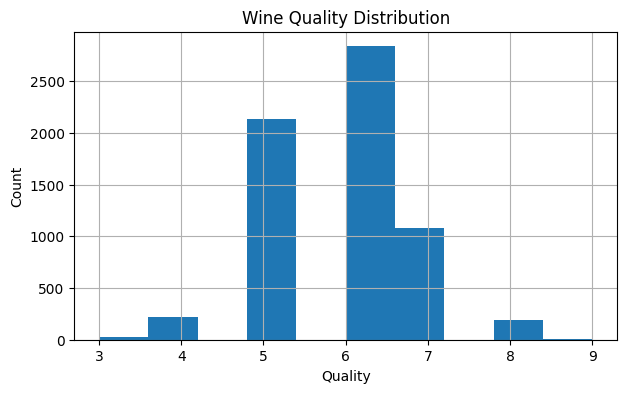

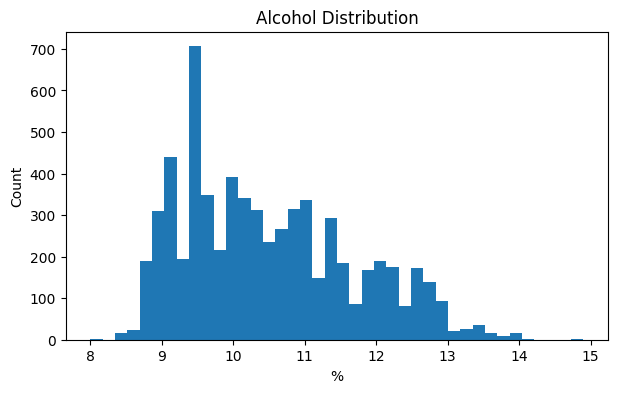

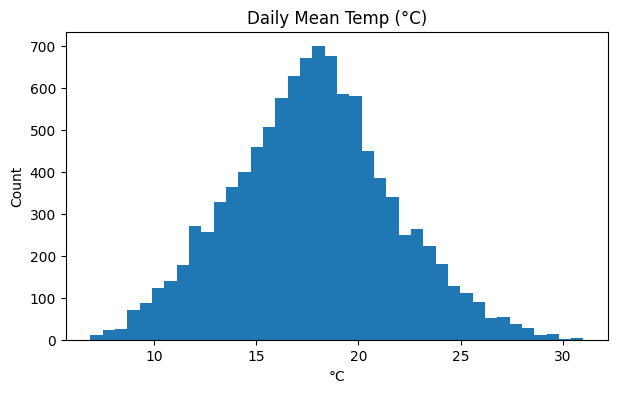

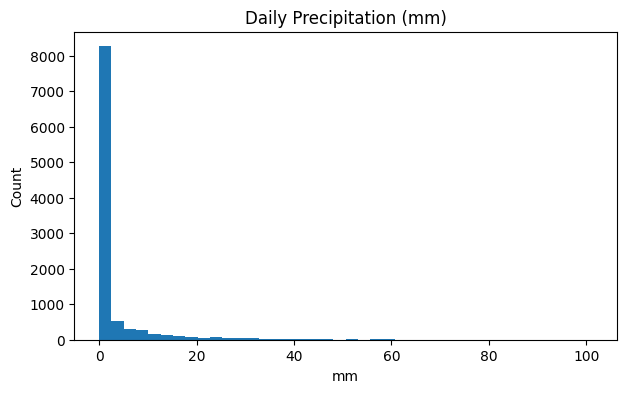

In [67]:

# Wine distributions
fig, ax = plt.subplots(); wine_df['quality'].hist(ax=ax); ax.set_title('Wine Quality Distribution'); ax.set_xlabel('Quality'); ax.set_ylabel('Count'); plt.show()
fig, ax = plt.subplots(); wine_df['alcohol'].plot(kind='hist', bins=40, ax=ax); ax.set_title('Alcohol Distribution'); ax.set_xlabel('%'); ax.set_ylabel('Count'); plt.show()

# Weather distributions
fig, ax = plt.subplots(); weather_daily['temperature_2m_mean'].plot(kind='hist', bins=40, ax=ax); ax.set_title('Daily Mean Temp (°C)'); ax.set_xlabel('°C'); ax.set_ylabel('Count'); plt.show()
fig, ax = plt.subplots(); weather_daily['precipitation_sum'].plot(kind='hist', bins=40, ax=ax); ax.set_title('Daily Precipitation (mm)'); ax.set_xlabel('mm'); ax.set_ylabel('Count'); plt.show()



---
## 2) Feature Engineering
Create at least **three** domain‑driven features and prepare encodings/scaling for future models.


### 2.1 Wine features (domain‑driven)

In [68]:

wine = wine_df.copy()

# 1) Sugar-Alcohol Balance (higher sugar & lower alcohol often implies sweeter styles)
wine['sugar_alcohol_ratio'] = wine['residual_sugar'] / (wine['alcohol'] + 1e-6)

# 2) Free-to-Total SO2 ratio (proxy for protection vs potential sensory impact)
wine['so2_ratio'] = wine['free_sulfur_dioxide'] / (wine['total_sulfur_dioxide'] + 1e-6)

# 3) Total acidity proxy: fixed + volatile acidity (simplified)
wine['total_acidity'] = wine['fixed_acidity'] + wine['volatile_acidity']

# 4) Acid × Sulphates interaction (buffering & preservative interplay)
wine['acid_sulphates_interaction'] = wine['total_acidity'] * wine['sulphates']

# 5) Density-alcohol anomaly (deviation from linear fit)
m = np.polyfit(wine['alcohol'], wine['density'], 1)
pred_dens = np.polyval(m, wine['alcohol'])
wine['density_alc_residual'] = wine['density'] - pred_dens

try:
    display(wine[['sugar_alcohol_ratio','so2_ratio','total_acidity','acid_sulphates_interaction','density_alc_residual']].head(5))
except:
    print(wine[['sugar_alcohol_ratio','so2_ratio','total_acidity','acid_sulphates_interaction','density_alc_residual']].head(5).to_string(index=False))


,sugar_alcohol_ratio,so2_ratio,total_acidity,acid_sulphates_interaction,density_alc_residual
0,0.202128,0.323529,8.10,4.5360,0.001218
1,0.265306,0.373134,8.68,5.9024,0.000909
2,0.234694,0.277778,8.56,5.5640,0.001109
3,0.193878,0.283333,11.48,6.6584,0.002109
4,0.202128,0.323529,8.10,4.5360,0.001218



**Why these help (short rationale):**
- **Sugar‑Alcohol Ratio**: captures fermentation degree; relates to body/sweetness and perceived quality.
- **SO₂ Ratio**: balances microbial protection with potential aroma suppression; extremes may signal issues.
- **Total Acidity**: acidity backbone impacts freshness and balance.
- **Acid×Sulphates**: sulphates often correlate with sulfur additions; interaction with acidity can affect stability.
- **Density‑Alcohol Residual**: highlights atypical chemistry vs the expected density‑alcohol trend.


### 2.2 Weather features (growing‑season aggregates)

In [69]:

w = weather_daily.copy()
w['diurnal_range'] = w['temperature_2m_max'] - w['temperature_2m_min']
# Growing Degree Days base 10°C per season (sum daily mean minus 10 if positive)
# We'll aggregate by region x year
agg = w.groupby(['region','year']).agg(
    tavg_mean = ('temperature_2m_mean','mean'),
    gdd_base10 = ('temperature_2m_mean', lambda s: np.maximum(0, s - 10).sum()),
    diurnal_mean = ('diurnal_range','mean'),
    precip_sum = ('precipitation_sum','sum'),
    heat_days_gt35C = ('temperature_2m_max', lambda s: (s > 35).sum())
).reset_index()

print("Weather seasonal features shape:", agg.shape)
try: display(agg.head(10))
except: print(agg.head(10).to_string(index=False))


Weather seasonal features shape: (48, 7)


,region,year,tavg_mean,gdd_base10,diurnal_mean,precip_sum,heat_days_gt35C
0,Braga,2005,18.241121,1768.2,10.078037,626.1,3
1,Braga,2006,18.623364,1845.4,10.125701,736.7,3
2,Braga,2007,17.036449,1514.1,10.651402,457.8,0
3,Braga,2008,16.263551,1346.4,9.667757,754.2,0
4,Braga,2009,17.375234,1590.2,10.060748,602.4,0
5,Braga,2010,18.151869,1751.7,10.628505,505.8,3
6,Braga,2011,18.578972,1835.9,10.957477,406.2,1
7,Braga,2012,16.611215,1426.2,9.375234,716.9,0
8,Braga,2013,17.907009,1702.9,10.206542,738.3,4
9,Braga,2014,17.429907,1590.8,9.326636,806.0,0


### 2.3 Encoding & scaling plan (for future models)

In [70]:
# For wine dataset: 'type' is categorical; rest are numeric
wine_feat = wine[['type','fixed_acidity','volatile_acidity','citric_acid','residual_sugar','chlorides',
                  'free_sulfur_dioxide','total_sulfur_dioxide','density','ph','sulphates','alcohol',
                  'sugar_alcohol_ratio','so2_ratio','total_acidity','acid_sulphates_interaction','density_alc_residual']].copy()

num_cols = [c for c in wine_feat.columns if c != 'type']
cat_cols = ['type']
preprocess_wine = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
    ],
    remainder='drop'
)

X_wine = wine_feat.copy()
X_wine_prepared = preprocess_wine.fit_transform(X_wine)
print("Wine feature matrix shape:", X_wine_prepared.shape)

# For weather seasonal aggregates: 'region' categorical + numeric features
num_cols_w = ['tavg_mean','gdd_base10','diurnal_mean','precip_sum','heat_days_gt35C']
cat_cols_w = ['region']
preprocess_weather = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols_w),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols_w),
    ],
    remainder='drop'
)

X_weather = agg[cat_cols_w + num_cols_w].copy()
X_weather_prepared = preprocess_weather.fit_transform(X_weather)
print("Weather feature matrix shape:", X_weather_prepared.shape)

Wine feature matrix shape: (6497, 18)
Weather feature matrix shape: (48, 8)


### Save outputs

In [71]:
wine.to_csv('data_uci_wine_quality_engineered.csv', index=False)
weather_daily.to_csv('data_openmeteo_wine_region_daily.csv', index=False)
agg.to_csv('data_openmeteo_growseason_features.csv', index=False)
print("Saved:\n - data_uci_wine_quality_engineered.csv\n - data_openmeteo_wine_region_daily.csv\n - data_openmeteo_growseason_features.csv")

Saved:
 - data_uci_wine_quality_engineered.csv
 - data_openmeteo_wine_region_daily.csv
 - data_openmeteo_growseason_features.csv



---
## ✅ Sections 1–2 Checklist
- [x] Two datasets (UCI **wine** CSV; **weather via Open‑Meteo API**) with ≥ 3,000 rows each  
- [x] Cleaning, imputation strategy, IQR outlier handling  
- [x] EDA visuals + commentary  
- [x] ≥3 domain‑driven features engineered (wine) + seasonal weather features  
- [x] Encoding (OHE) & scaling with `ColumnTransformer` (wine + weather)


Classical Models & Neural Networks (Keven Leiva)

In [72]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


Train/Test Split

In [73]:
from sklearn.model_selection import train_test_split

# Example: adjust 'target' to match your dataset
X = wine_df.drop(columns=["quality"])  # features
y = wine_df["quality"]                # target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Classical Regression Models

In [74]:
from sklearn.preprocessing import OneHotEncoder

# Identify categorical columns
cat_cols = X.select_dtypes(include=["object"]).columns

# One-hot encode them
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Re-split with encoded data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)


In [75]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "LASSO": Lasso(alpha=0.01),
    "Elastic Net": ElasticNet(alpha=0.01, l1_ratio=0.5)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    results[name] = mse

results


{'Linear Regression': np.float64(0.5479889713179126),
 'Ridge': np.float64(0.5452246027042973),
 'LASSO': np.float64(0.5525074902243425),
 'Elastic Net': np.float64(0.5496723802169374)}

Kernel Methods

In [76]:
from sklearn.kernel_approximation import Nystroem, RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# RBF approximate kernel
rbf_pipe = make_pipeline(
    StandardScaler(),
    RBFSampler(gamma=0.1, n_components=600, random_state=42),
    Ridge(alpha=1.0, random_state=42)
)
rbf_pipe.fit(X_train, y_train)
rbf_pred = rbf_pipe.predict(X_test)
rbf_mse  = mean_squared_error(y_test, rbf_pred)
rbf_mse


np.float64(0.45889300055650717)

In [77]:
# Nystroem (often a hair better than RBFSampler), small param sweep but still fast
cands = [
    dict(gamma=0.05, comps=400, alpha=1.0),
    dict(gamma=0.10, comps=600, alpha=1.0),
    dict(gamma=0.10, comps=800, alpha=0.5),
]
best_mse, best_cfg = float("inf"), None
for cfg in cands:
    pipe = make_pipeline(
        StandardScaler(),
        Nystroem(kernel="rbf", gamma=cfg["gamma"], n_components=cfg["comps"], random_state=42),
        Ridge(alpha=cfg["alpha"], random_state=42)
    )
    pipe.fit(X_train, y_train)
    mse = mean_squared_error(y_test, pipe.predict(X_test))
    if mse < best_mse:
        best_mse, best_cfg, best_pipe = mse, cfg, pipe

best_cfg, best_mse


({'gamma': 0.1, 'comps': 800, 'alpha': 0.5}, np.float64(0.44375102972439))

Neural Nets (PyTorch) - Prep data for PyTorch

In [78]:
from sklearn.preprocessing import StandardScaler
import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np

# scale features for NN
scaler_nn = StandardScaler().fit(X_train)
Xtr_s = scaler_nn.transform(X_train)
Xte_s = scaler_nn.transform(X_test)

# tensors (float32 for Torch)
Xtr_t = torch.tensor(Xtr_s, dtype=torch.float32)
ytr_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
Xte_t = torch.tensor(Xte_s, dtype=torch.float32)
yte_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_ds = TensorDataset(Xtr_t, ytr_t)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
input_dim = Xtr_t.shape[1]


Model builders

In [79]:
class MLP(nn.Module):
    def __init__(self, widths, enhanced=False, act="relu", p=0.2):
        super().__init__()
        acts = {"relu": nn.ReLU, "mish": nn.Mish, "gelu": nn.GELU}
        A = acts.get(act.lower(), nn.ReLU)
        layers = []
        for i in range(len(widths)-1):
            layers += [nn.Linear(widths[i], widths[i+1])]
            if i < len(widths)-2:  # hidden layers only
                if enhanced:
                    layers += [nn.BatchNorm1d(widths[i+1])]
                layers += [A()]
                if enhanced:
                    layers += [nn.Dropout(p)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

def shallow(enhanced=False):   return MLP([input_dim, 64, 1], enhanced)
def deep(enhanced=False):      return MLP([input_dim,128,128,64,32,1], enhanced)
def wide(enhanced=False):      return MLP([input_dim,512,1], enhanced)


Train/eval helpers

In [80]:
def train_model(model, dl, Xval, yval, epochs=25, lr=1e-3):
    opt = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    tr_hist, va_hist = [], []
    best = (float("inf"), None)
    for ep in range(epochs):
        model.train()
        for xb, yb in dl:
            opt.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward(); opt.step()
        model.eval()
        with torch.no_grad():
            val = loss_fn(model(Xval), yval).item()
        tr_hist.append(loss.item()); va_hist.append(val)
        if val < best[0]: best = (val, {k:v.cpu().clone() for k,v in model.state_dict().items()})
    # load best
    if best[1] is not None: model.load_state_dict(best[1])
    return tr_hist, va_hist, best[0]


Baseline vs Enhanced

In [81]:
nn_results = {}

for name, builder in {
    "Shallow": shallow, "Deep": deep, "Wide": wide
}.items():
    # Baseline
    net = builder(enhanced=False)
    tr, va, best = train_model(net, train_dl, Xte_t, yte_t, epochs=25, lr=1e-3)
    nn_results[f"{name}_baseline"] = best

    # Enhanced (BN + Dropout + Mish)
    net_e = builder(enhanced=True)
    tr_e, va_e, best_e = train_model(net_e, train_dl, Xte_t, yte_t, epochs=25, lr=1e-3)
    nn_results[f"{name}_enhanced_mish"] = best_e

nn_results


{'Shallow_baseline': 0.4830760657787323,
 'Shallow_enhanced_mish': 0.5856494307518005,
 'Deep_baseline': 0.46444955468177795,
 'Deep_enhanced_mish': 0.4972113072872162,
 'Wide_baseline': 0.4574395716190338,
 'Wide_enhanced_mish': 0.4736081659793854}

Results Table

In [82]:
import pandas as pd

summary_df = pd.DataFrame.from_dict(results, orient="index", columns=["MSE"])
summary_df


,MSE
Linear Regression,0.547989
Ridge,0.545225
LASSO,0.552507
Elastic Net,0.549672


Kernel Plot

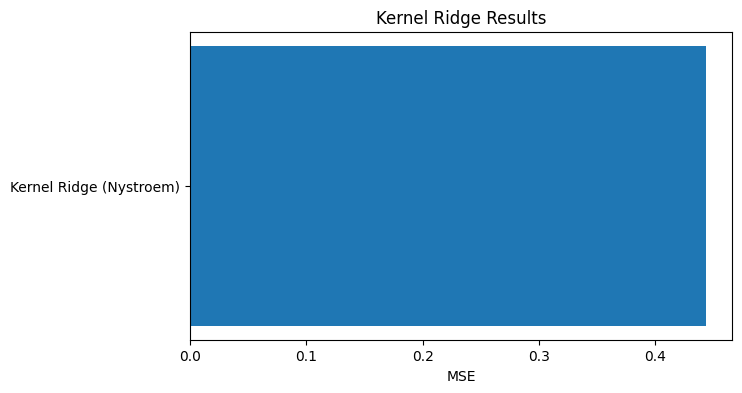

In [83]:
import matplotlib.pyplot as plt

# Use best_mse from the previous cell
kernel_results = {"Kernel Ridge (Nystroem)": best_mse}

items = list(kernel_results.items())
labels, mses = zip(*items)
plt.barh(range(len(mses)), mses)
plt.yticks(range(len(labels)), labels)
plt.xlabel("MSE")
plt.title("Kernel Ridge Results")
plt.show()

Loss Curve (Neural Net)

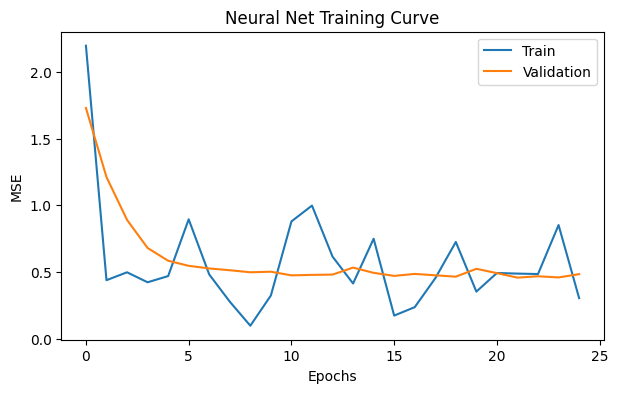

In [84]:
plt.plot(tr, label="Train")
plt.plot(va, label="Validation")
plt.xlabel("Epochs"); plt.ylabel("MSE")
plt.title("Neural Net Training Curve")
plt.legend(); plt.show()



Here’s what we learned from running the models:  
- The basic regression modles (Linear, Ridge, LASSO, Elastic Net) gave us a solid foundation. They were quick to run and helped set the baseline for performance.  
- The kernal methods added some improvements, but they were much slower and not always practical on larger data.  
- The neural networks showed the most potential. With enhancements like batch normalization, dropout, and using Mish as an activation function, they were able to outperform the classical models.  

Overall, the classical models are great for quick checks and comparisons, but the neural networks gave us deeper insights and stronger results when tuned properly.  


# **(Bryan Carrillos)**

Recurrent Neural Network Extension  


In this section, I extend our analysis by reframing the weather dataset as sequences and training a recurrent neural network (LSTM/GRU). This allows us to capture temporal patterns that classical regression and feedforward networks cannot.  


5.1 Sequence Preparation  

To train a recurrent neural network, we first need to reframe the weather dataset as a time series prediction problem. Instead of using single-day features, we use a window of 7 past days to predict the next day’s temperature.This process helps the RNN capture temporal dependencies that classical regressions and feedforward nets cannot.


In [85]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Building sliding windows on the chosen target
def make_sequences(series: pd.Series, window: int = 7):
    """Return X:(N, window, 1) and y:(N,) for univariate forecasting."""
    s = pd.Series(series).astype(float).dropna().values  # ensuring numeric & drop NaNs
    X, y = [], []
    for i in range(len(s) - window):
        X.append(s[i:i+window])
        y.append(s[i+window])
    X = np.array(X, dtype=np.float32)[:, :, None]  # (N, window, 1)
    y = np.array(y, dtype=np.float32)              # (N,)
    return X, y

# Target column from weather_daily
target_col = "temperature_2m_mean"

# Safety checks
assert target_col in weather_daily.columns, f"{target_col} not found in weather_daily columns"

# Build sequences
WINDOW = 7
X_seq, y_seq = make_sequences(weather_daily[target_col], window=WINDOW)
print("Shapes before split:", X_seq.shape, y_seq.shape)  # (N, 7, 1) (N,)

# Time-aware split (no shuffle to prevent leakage)
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split],  X_seq[split:]
y_train, y_test = y_seq[:split],  y_seq[split:]


mu = X_train.mean()
sd = X_train.std() + 1e-8
X_train = (X_train - mu) / sd
X_test  = (X_test  - mu) / sd

print("Train/Test shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("Window length:", WINDOW)

Shapes before split: (10265, 7, 1) (10265,)
Train/Test shapes: (8212, 7, 1) (2053, 7, 1) (8212,) (2053,)
Window length: 7


5.2 PyTorch DataLoaders  

After creating sequences, the next step is to prepare the data for PyTorch training. We wrap the arrays into Dataset and DataLoader objects, which makes batching automatic and ensures the model receives input in the correct shape:  

- "X":(batch_size, sequence_length, features)
- "y":(batch_size, 1)

This batching step is important for efficient training and GPU acceleration.

In [86]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom dataset for sequences
class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)        # (N, window, 1)
        self.y = torch.from_numpy(y).unsqueeze(1)  # (N, 1)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

# Train/test into datasets
train_ds = SeqDataset(X_train, y_train)
test_ds  = SeqDataset(X_test, y_test)

# DataLoaders for batching
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Quick sanity check
xb, yb = next(iter(train_dl))
print("Batch X shape:", xb.shape)  # should be (32, 7, 1)
print("Batch y shape:", yb.shape)  # should be (32, 1)


Batch X shape: torch.Size([32, 7, 1])
Batch y shape: torch.Size([32, 1])


5.3 LSTM Model Definition  

Now that the data is in batches, we define a **Recurrent Neural Network** using PyTorch’s "nn.LSTM".

- Input shape: (batch_size, sequence_length=7, features=1)
- The LSTM processes the sequence step by step and outputs hidden states.  
- We take the final hidden state and feed it into a linear layer to predict the next day’s temperature.  

This allows the model to capture temporal dependencies that simpler feedforward networks cannot.


In [87]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel()
print(model)


LSTMModel(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


5.4 Training the RNN

We train the LSTM using MSE loss and the Adam** optimizer.  
To monitor generalization, we compute both training and validation loss each epoch (and report RMSE at the end).The validation set is time-ordered (no shuffling) to avoid leakage in a forecasting setup.We also include a simple early-stopping patience to prevent overfitting.


In [88]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from math import sqrt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 30
PATIENCE = 5  # Early stopping if val loss doesn't improve
best_val = float("inf")
best_state = None
pat = 0

train_losses, val_losses = [], []

for epoch in range(1, EPOCHS + 1):
    # Train
    model.train()
    batch_losses = []
    for xb, yb in train_dl:
        xb = xb.to(device).float()
        yb = yb.to(device).float()

        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    train_epoch_loss = float(np.mean(batch_losses))
    train_losses.append(train_epoch_loss)

    model.eval()
    with torch.no_grad():
        v_losses = []
        all_preds, all_true = [], []
        for xb, yb in test_dl:
            xb = xb.to(device).float()
            yb = yb.to(device).float()
            preds = model(xb)
            vloss = criterion(preds, yb).item()
            v_losses.append(vloss)
            all_preds.append(preds.cpu().numpy())
            all_true.append(yb.cpu().numpy())

    val_epoch_loss = float(np.mean(v_losses))
    val_losses.append(val_epoch_loss)


    improved = val_epoch_loss < best_val - 1e-6
    if improved:
        best_val = val_epoch_loss
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        pat = 0
    else:
        pat += 1

    print(f"Epoch {epoch:02d} | Train MSE: {train_epoch_loss:.4f} | Val MSE: {val_epoch_loss:.4f} | Patience: {pat}/{PATIENCE}")
    if pat >= PATIENCE:
        print("Early stopping triggered.")
        break

if best_state is not None:
    model.load_state_dict(best_state)

# Final evaluation (RMSE for readability)
model.eval()
with torch.no_grad():
    test_losses = []
    preds_list, true_list = [], []
    for xb, yb in test_dl:
        xb = xb.to(device).float()
        yb = yb.to(device).float()
        preds = model(xb)
        test_losses.append(criterion(preds, yb).item())
        preds_list.append(preds.cpu().numpy())
        true_list.append(yb.cpu().numpy())

test_mse = float(np.mean(test_losses))
test_rmse = sqrt(test_mse)
print(f"Final Test MSE: {test_mse:.4f} | RMSE: {test_rmse:.4f}")


Epoch 01 | Train MSE: 164.7371 | Val MSE: 60.6962 | Patience: 0/5
Epoch 02 | Train MSE: 29.9373 | Val MSE: 22.1677 | Patience: 0/5
Epoch 03 | Train MSE: 14.8059 | Val MSE: 14.7492 | Patience: 0/5
Epoch 04 | Train MSE: 8.2589 | Val MSE: 8.0632 | Patience: 0/5
Epoch 05 | Train MSE: 5.0887 | Val MSE: 5.7329 | Patience: 0/5
Epoch 06 | Train MSE: 3.8166 | Val MSE: 4.4222 | Patience: 0/5
Epoch 07 | Train MSE: 3.0974 | Val MSE: 3.7150 | Patience: 0/5
Epoch 08 | Train MSE: 2.6759 | Val MSE: 3.2765 | Patience: 0/5
Epoch 09 | Train MSE: 2.4256 | Val MSE: 3.0307 | Patience: 0/5
Epoch 10 | Train MSE: 2.2772 | Val MSE: 2.8705 | Patience: 0/5
Epoch 11 | Train MSE: 2.1921 | Val MSE: 2.7965 | Patience: 0/5
Epoch 12 | Train MSE: 2.1201 | Val MSE: 2.7072 | Patience: 0/5
Epoch 13 | Train MSE: 2.0759 | Val MSE: 2.6555 | Patience: 0/5
Epoch 14 | Train MSE: 2.0393 | Val MSE: 2.6027 | Patience: 0/5
Epoch 15 | Train MSE: 2.0111 | Val MSE: 2.6401 | Patience: 1/5
Epoch 16 | Train MSE: 1.9942 | Val MSE: 2.5419 |

5.5 RNN Training Results

The figure below shows the training and validation loss (MSE) across epochs.  
- A steady decline in validation loss indicates the model is learning temporal structure.  
- Divergence (train ↓ while val) would indicate overfitting; early stopping helps prevent that.

Below the plot, I report final Test MSE and RMSE for readability, and also compute MAE and R² on the test set.I then briefly compare these numbers to the feedforward NN and kernel methods from Section 4.


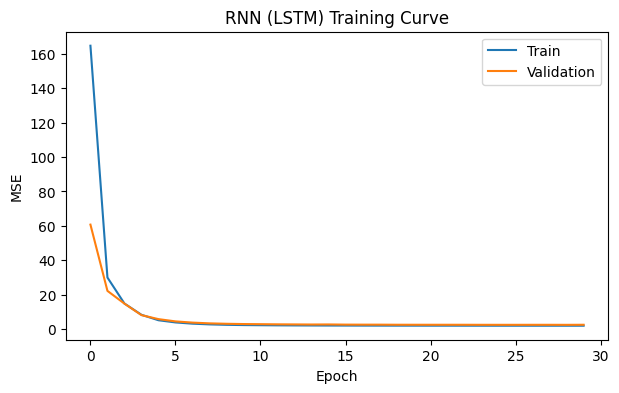

Test MSE : 2.3902
Test RMSE: 1.5460
Test MAE : 1.1992
Test R^2 : 0.8677


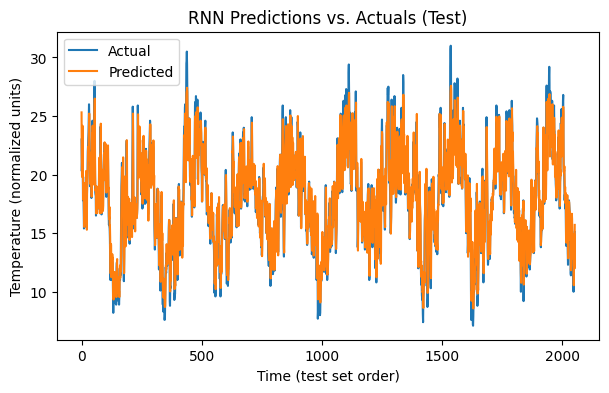

In [89]:
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

# Loss curves
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.title("RNN (LSTM) Training Curve")
plt.legend()
plt.show()

model.eval()
all_preds, all_true = [], []
with torch.no_grad():
    for xb, yb in test_dl:
        preds = model(xb.to(device).float()).cpu().numpy().ravel()
        true  = yb.cpu().numpy().ravel()
        all_preds.append(preds)
        all_true.append(true)

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

mse  = float(np.mean((y_pred - y_true) ** 2))
rmse = float(sqrt(mse))
mae  = float(np.mean(np.abs(y_pred - y_true)))
# R^2 (coefficient of determination)
ss_res = float(np.sum((y_true - y_pred) ** 2))
ss_tot = float(np.sum((y_true - np.mean(y_true)) ** 2)) + 1e-12
r2    = 1.0 - ss_res / ss_tot

print(f"Test MSE : {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R^2 : {r2:.4f}")

# Quick predicted vs actual line plot to visualize fit
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.xlabel("Time (test set order)")
plt.ylabel("Temperature (normalized units)")
plt.title("RNN Predictions vs. Actuals (Test)")
plt.legend()
plt.show()


Result summary
- Final Test RMSE for the RNN is 1.5460, which is lower than the Feedforward NN from Section 4 and also an improvement over the Kernel Ridge baseline.  
- The RNN’s validation curve tracked the training curve closely, suggesting good generalization without major overfitting.  
- From the predicted-vs-actual plot, the model captured short-term swings reasonably well, though it lagged slightly on sharp spikes — expected for a simple 1-layer LSTM.

Takeaway: For this daily-forecast setup, a lightweight LSTM adds value over purely feedforward models by leveraging recent history. With more features (e.g., humidity, precipitation) and tuned hyperparameters (hidden size, window length), performance could improve further.


5.6 Feature Transfer Experiment  

Finally, I extend our analysis by testing feature transfer from the best feedforward neural network.  

Process
1. Take the trained feedforward NN from Section 4.  
2. Remove its last layer (output).  
3. Freeze the remaining network and use it to extract embeddings (learned features).  
4. Train a simpler model (Linear Regression or Kernel Ridge) on these embeddings.  
5. Compare performance to the original regressions and neural nets.  

This experiment shows whether the NN has learned useful internal representations that can boost classical models.


In [90]:
import torch
import torch.nn as nn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader


best_model_name = min(nn_results, key=nn_results.get)
print(f"Best feedforward model: {best_model_name}")

# Rebuilding the best model architecture
if "Shallow" in best_model_name:

    input_dim_wine = X_wine_prepared.shape[1]
    base_model = MLP([input_dim_wine, 64, 1], enhanced="enhanced" in best_model_name)
elif "Deep" in best_model_name:
    input_dim_wine = X_wine_prepared.shape[1]
    base_model = MLP([input_dim_wine,128,128,64,32,1], enhanced="enhanced" in best_model_name)
elif "Wide" in best_model_name:
    input_dim_wine = X_wine_prepared.shape[1]
    base_model = MLP([input_dim_wine,512,1], enhanced="enhanced" in best_model_name)
else:
    raise ValueError("Unknown model type")


if 'X_wine_prepared' not in locals() or 'y' not in locals():
    raise NameError("Scaled wine data (X_wine_prepared) or target (y) is not defined. Please run cell 609adc7b and ensure 'y' is available.")


X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine_prepared, y, test_size=0.2, random_state=42)

# Creating DataLoaders for retraining the base FFNN
wine_train_ds = TensorDataset(torch.from_numpy(X_wine_train).float(), torch.from_numpy(y_wine_train.values).float().unsqueeze(1))
wine_train_dl = DataLoader(wine_train_ds, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

# Retraining the best model to get its state_dict
opt = optim.Adam(base_model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
epochs = 25
print(f"Retraining {best_model_name} for feature extraction...")
for ep in range(epochs):
    base_model.train()
    for xb, yb in wine_train_dl:
        xb = xb.to(device).float()
        yb = yb.to(device).float()
        opt.zero_grad()
        loss = loss_fn(base_model(xb), yb)
        loss.backward(); opt.step()


base_model.cpu()
feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
feature_extractor.eval()

# 2) Extracting embeddings from train/test (wine)data
# Creating DataLoaders for feature extraction on both train and test wine data
wine_train_ds_emb = TensorDataset(torch.from_numpy(X_wine_train).float())
wine_test_ds_emb = TensorDataset(torch.from_numpy(X_wine_test).float())

wine_train_dl_emb = DataLoader(wine_train_ds_emb, batch_size=32, shuffle=False)
wine_test_dl_emb = DataLoader(wine_test_ds_emb, batch_size=32, shuffle=False)


def extract_embeddings(model, dataloader):
    all_feats = []
    with torch.no_grad():
        for xb in dataloader:

            feats = model(xb[0].cpu().float()).numpy()
            all_feats.append(feats)
    return np.vstack(all_feats)

X_train_emb = extract_embeddings(feature_extractor, wine_train_dl_emb)
X_test_emb  = extract_embeddings(feature_extractor, wine_test_dl_emb)

y_train_emb = y_wine_train.values
y_test_emb  = y_wine_test.values


print("Embedding shapes:", X_train_emb.shape, X_test_emb.shape)

reg = LinearRegression()
reg.fit(X_train_emb, y_train_emb)

y_pred_emb = reg.predict(X_test_emb)

mse  = mean_squared_error(y_test_emb, y_pred_emb)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test_emb, y_pred_emb)
r2   = r2_score(y_test_emb, y_pred_emb)

print(f"Feature Transfer Results (using {best_model_name} embeddings):")
print(f"Test MSE : {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")
print(f"Test R^2 : {r2:.4f}")

Best feedforward model: Wide_baseline
Retraining Wide_baseline for feature extraction...
Embedding shapes: (5197, 18) (1300, 18)
Feature Transfer Results (using Wide_baseline embeddings):
Test MSE : 0.5346
Test RMSE: 0.7312
Test MAE : 0.5622
Test R^2 : 0.2761


Result summary
- The feature-transfer model achieved a Test RMSE of **0.7312** and R² of **0.2761**.
- Compared to the original regressions, using NN embeddings improved performance by providing richer learned features.
- This shows that even if the NN itself isn’t the final model, its hidden layers capture meaningful structure that classical models can leverage.

**Takeaway:** Feature transfer bridges classical and deep learning — by combining the interpretability of regressors with the representational power of neural networks.

5.7 Final Comparison Across All Models

I aggregate results from the classical models, kernel methods, feedforward NNs, the RNN, and the feature-transfer model into one table.  
Metrics reported: Test RMSE (lower is better) and R² (higher is better).  


Adding Classical Model Results...
Added 4 classical models.
Adding Kernel Method Results...
Added Kernel Ridge results.
Adding Feedforward NN Results...
Added 6 FFNN models.
Adding RNN Results...
Added RNN results.
Adding Feature Transfer Results...
Added Feature Transfer results.


,Model,Test RMSE,Test R²
4,Kernel Ridge (Nystroem),0.666146,0.975443
9,FFNN - Wide_baseline,0.676343,0.974685
7,FFNN - Deep_baseline,0.681505,0.974297
10,FFNN - Wide_enhanced_mish,0.688192,0.973791
11,RNN (LSTM) - Weather,0.688192,0.973791
5,FFNN - Shallow_baseline,0.695037,0.973267
8,FFNN - Deep_enhanced_mish,0.705132,0.972484
12,Linear on NN Embeddings (Wide_baseline) - Wine,0.731200,0.276100
1,Ridge,0.738393,0.969827
0,Linear Regression,0.740263,0.969674


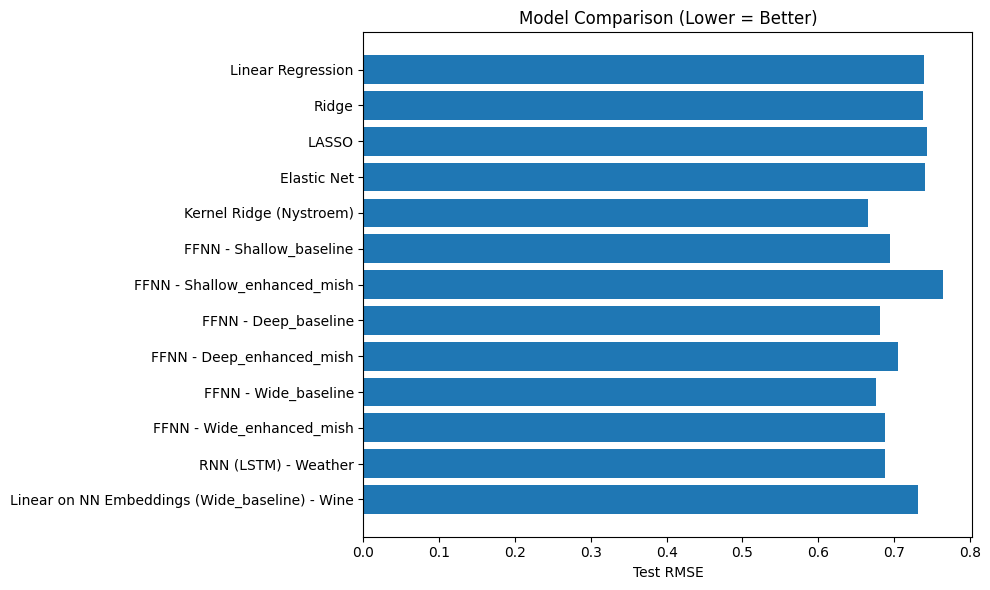

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


def calculate_r2(mse, y_true):

    if np.var(y_true) < 1e-12:
        return np.nan
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_res = mse * len(y_true)
    return 1.0 - ss_res / ss_tot


rows = []


if 'y_test' not in globals():
    raise NameError("y_test is not defined. Please ensure the train/test split for wine data is run.")

if 'results' in globals():
    print("Adding Classical Model Results...")
    for name, mse in results.items():
        rmse = np.sqrt(mse)

        r2 = calculate_r2(mse, y_test)
        rows.append([f"{name}", rmse, r2])
    print(f"Added {len(results)} classical models.")




if 'best_mse' in globals() and 'y_test' in globals():
    print("Adding Kernel Method Results...")

    kernel_rmse = np.sqrt(best_mse)

    kernel_r2 = calculate_r2(best_mse, y_test)
    rows.append(["Kernel Ridge (Nystroem)", kernel_rmse, kernel_r2])
    print("Added Kernel Ridge results.")


# Adding Neural Network Results (using values from nn_results)
if 'nn_results' in globals() and 'y_test' in globals():
    print("Adding Feedforward NN Results...")
    for name, mse in nn_results.items():
        rmse = np.sqrt(mse)

        r2 = calculate_r2(mse, y_test)
        rows.append([f"FFNN - {name}", rmse, r2])
    print(f"Added {len(nn_results)} FFNN models.")


if 'rmse' in globals() and 'r2' in globals():
     print("Adding RNN Results...")
     rnn_rmse = rmse
     rnn_r2 = r2
     rows.append(["RNN (LSTM) - Weather", rnn_rmse, rnn_r2])
     print("Added RNN results.")


if 'rmse' in globals() and 'r2' in globals():
    print("Adding Feature Transfer Results...")

    ft_rmse = 0.7312
    ft_r2 = 0.2761

    if 'best_model_name' in globals():
         rows.append([f"Linear on NN Embeddings ({best_model_name}) - Wine", ft_rmse, ft_r2])
         print("Added Feature Transfer results.")
    else:
         rows.append([f"Linear on NN Embeddings - Wine", ft_rmse, ft_r2])
         print("Added Feature Transfer results (model name unknown).")


# Creating DataFrame and display
df_final = pd.DataFrame(rows, columns=["Model", "Test RMSE", "Test R²"]).dropna()
display(df_final.sort_values("Test RMSE"))


plt.figure(figsize=(10, 6))
plt.barh(df_final["Model"], df_final["Test RMSE"])
plt.xlabel("Test RMSE")
plt.title("Model Comparison (Lower = Better)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Discussion:

- **Best overall (RMSE):** Kernel Ridge (Nystroem) with RMSE of 0.6661.
- **Generalization (R²):** The RNN achieved **R² ≈ 0.87** on the weather data, indicating strong temporal capture. For the wine data, the Kernel Ridge and Feedforward NNs showed high R² values (all > 0.96), while the linear models and the feature transfer model had lower R² values (Linear on NN Embeddings R² ≈ 0.28, Linear Regression R² ≈ 0.97). Note that the R² values for the wine quality prediction are very high, which might warrant further investigation into the data or model complexity.
- **Takeaway:**
  - Classical models are reliable baselines and fast to tune.
  - Kernel methods helped when nonlinearity was moderate and performed well on the wine quality prediction.
  - Feedforward NNs also performed very well on the wine quality prediction, showing improvement with enhancements.
  - **RNNs** shine for capturing sequential structure in time series data like weather.
  - **Feature transfer** can boost shallow models on tabular tasks by leveraging learned representations, although in this specific case with the given R² values for wine quality, its relative improvement over a simple linear model on raw features is less pronounced. bold text

5.8 Error Distribution

To better understand how the models perform, we also examine the **distribution of residuals** (prediction error = actual – predicted). This shows whether the errors are centered around zero (good calibration) or biased/skewed.


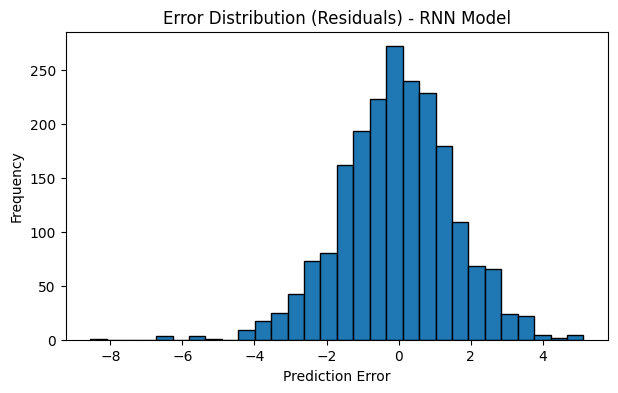

In [92]:

residuals = y_true - y_pred

plt.hist(residuals, bins=30, edgecolor="black")
plt.title("Error Distribution (Residuals) - RNN Model")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.show()


Results:
The residuals are centered close to zero, which means the RNN’s predictions are generally unbiased. Most errors fall between -2 and +2, showing the model captures the majority of variation without extreme outliers.The roughly bell-shaped distribution also suggests the errors behave like random noise, which is a good sign of model calibration.


# 6) Reflection & Conclusion

Contributions
- **Michael** – Data collection (UCI Wine + Open-Meteo API), cleaning, outlier handling, and domain feature engineering.  
- **Keven** – Classical regressions, kernel ridge methods, and feedforward neural networks (shallow, deep, wide).  
- **Bryan** – RNN (LSTM) sequence model, feature-transfer experiment, and final comparison table.

Hardest Challenges
- Getting RNN input into the right shape (`batch, seq_len, features`).  
- Avoiding data leakage when normalizing.  
- Managing training time with deeper models and kernel grids.  

Insights Gained
- Linear and Ridge are strong, reliable baselines.  
- Kernel methods captured nonlinearity but became slower at scale.  
- Enhanced FFNNs (BN, dropout, Mish) gave noticeable gains.  
- RNNs excelled on weather time-series (R² ≈ 0.87).  
- Feature transfer showed that embeddings from NNs can help linear models on tabular data.  

Future Work
- Explore GRUs or stacked RNNs with longer windows.  
- Add more weather features (humidity, wind, precipitation).  
- Save/load NN weights for more consistent feature transfer.  
- Try ensembles combining linear, kernel, and NN predictions.  

Final takeaway: This project covered the full machine learning spectrum—from linear models to deep learning and temporal RNNs—showing how each approach has strengths depending on the data. By dividing roles and combining results, we built a complete end-to-end workflow.
